# APLICACIONES DE CIENCIAS DE LA COMPUTACIÓN (INF265)
## (Segundo Semestre 2023)

## Laboratorio 4: Búsqueda Local (Hill Climbing, Simulated Annealing)

Indicaciones generales:

- Duración: **110 minutos (1 hora 50 min)**.
- **Las respuestas deben contar con un buen fundamento teórico**, se realizarán descuentos en el puntaje a respuestas que no contesten a lo solicitado.
- Cualquier indicio de plagio resultará en la anulación de la prueba.
- Debe presentar sus respuestas en base a los resultados de ejecución en los casos que se solicite.
- **No se calificarán aquellas respuestas que no presenten un resultado de ejecución o que no concuerden con este.**
- Subir el cuadernillo con el nombre **Lab4_código.ipynb**, donde código es su código PUCP de 8 dígitos.  
- Se tomará en cuenta en la calificación el uso de comentarios relevantes.

Objetivos:
- Identificar y elaborar correctamente el score
- Elaborar los algoritmos Hill Climbing y Simulated Annealing de manera que resuelva un problema de maximización con el score previamente definido
- Comparar los diferentes métodos de búsqueda local
- Identificar qué tipo de búsqueda local es mejor de acuerdo a un escenario en específico
- Relacionar los conceptos aprendidos sobre problemas de búsqueda local con escenarios de la vida cotidiana

## Caso: Conexión de Ciudades mediante Antenas

Una reconocida empresa de telecomunicación quiere conectar dos ciudades distantes mediante antenas. Sin embargo, las ciudades no están conectadas directamente, sino que es necesario recorrer ciudades intermedias para conectar las dos ciudades debido a dificultades del terreno en el que están ubicadas las ciudades.
<br>
<br>
Se debe tener en cuenta que construir y colocar antenas en cada ciudad es un proceso costoso, al igual que realizar la conexión entre las antenas usando cables por las distancias que existen entre las ciudades. Por ello, es necesario encontrar una ruta entre las ciudades que permita usar la menor cantidad de antenas a la par del menor costo de cables entre las antenas para realizar la conexión entre las dos ciudades.

A continuación, se presenta el mapa de las ciudades, donde los vértices son las ciudades y las aristas el costo de cable entre 2 ciudades:

<center>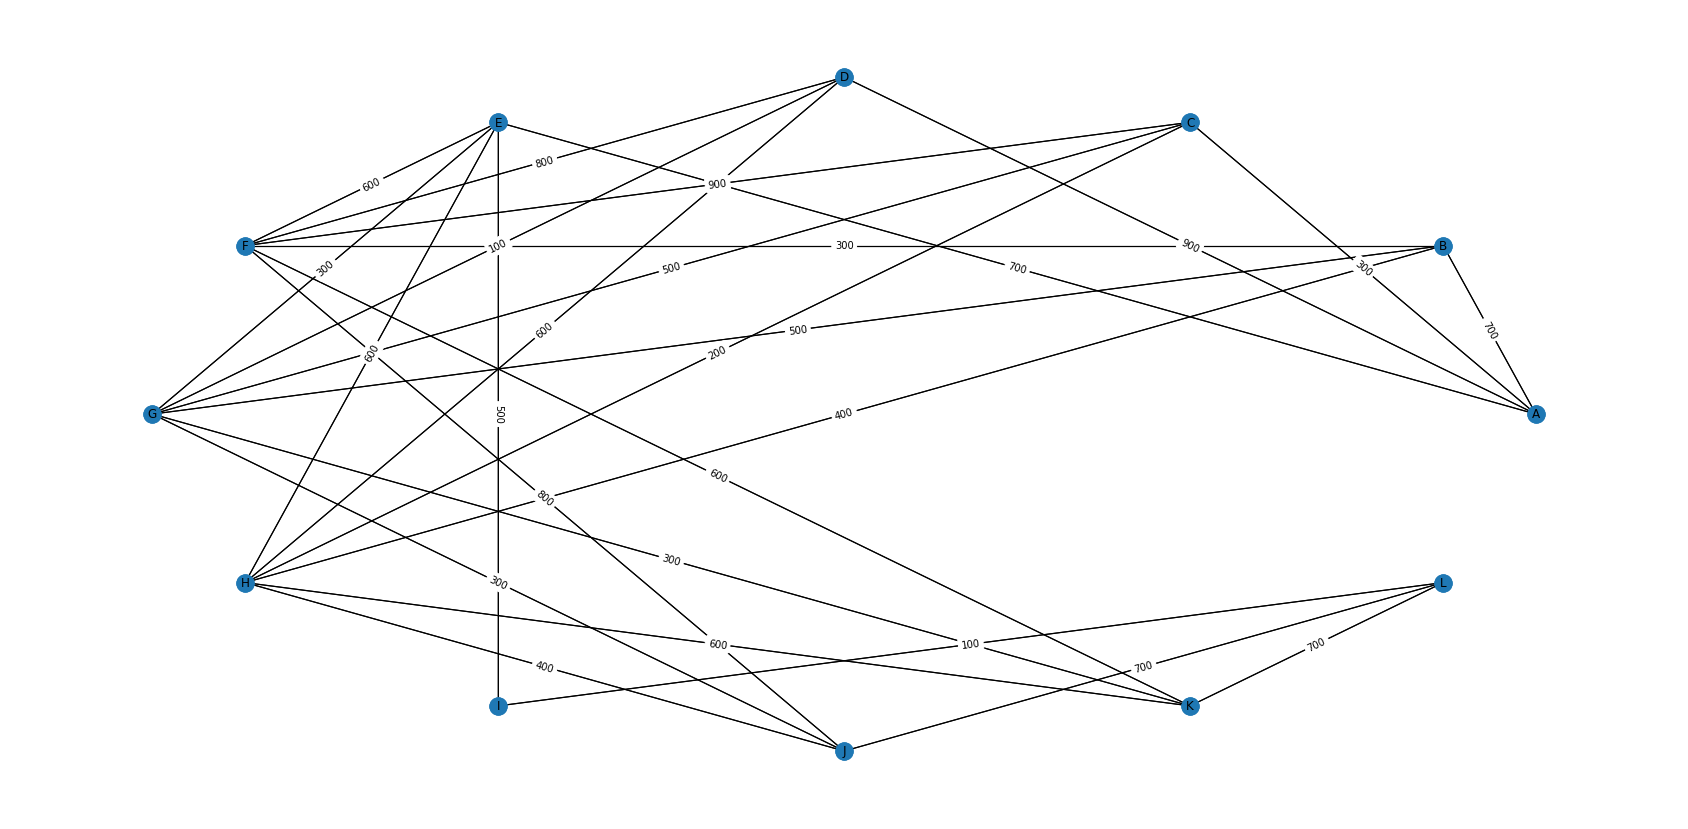</center>

Por simplicidad, el mapa de las ciudades es representado mediante una matriz de distancias que simula el costo de los cables entre las ciudades. Tener presente que el costo de los cables no es igual a la distancia entre las ciudades, sino que es una representación por simplicidad:

```
[[None,  700,  300,  900,  700, None, None, None, None, None, None, None],
 [ 700, None, None, None, None,  300,  500,  400, None, None, None, None],
 [ 300, None, None, None, None,  900,  500,  200, None, None, None, None],
 [ 900, None, None, None, None,  800,  100,  600, None, None, None, None],
 [ 700, None, None, None, None,  600,  300,  600,  500, None, None, None],
 [None,  300,  900,  800,  600, None, None, None, None,  800,  600, None],
 [None,  500,  500,  100,  300, None, None, None, None,  300,  300, None],
 [None,  400,  200,  600,  600, None, None, None, None,  400,  600, None],
 [None, None, None, None,  500, None, None, None, None, None, None,  100],
 [None, None, None, None, None,  800,  300,  400, None, None, None,  700],
 [None, None, None, None, None,  600,  300,  600, None, None, None,  700],
 [None, None, None, None, None, None, None, None,  100,  700,  700, None]]
```

El objetivo es conectar las ciudades "A" y "L", siendo que un camino entre entre la ciudad "A" y "L" representa un estado para los algoritmos a desarrollar.
<br>
<br>
Por ejemplo, un posible estado haciendo uso de la matriz de distancias es [0, 2, 6, 10, 11], que representado mediante los nombres de las ciudades indica el camino ["A", "C", "G", "K", "L"]. A continuación, se muestra de manera gráfica el estado planteado en el ejemplo mediante líneas naranjas:

<center>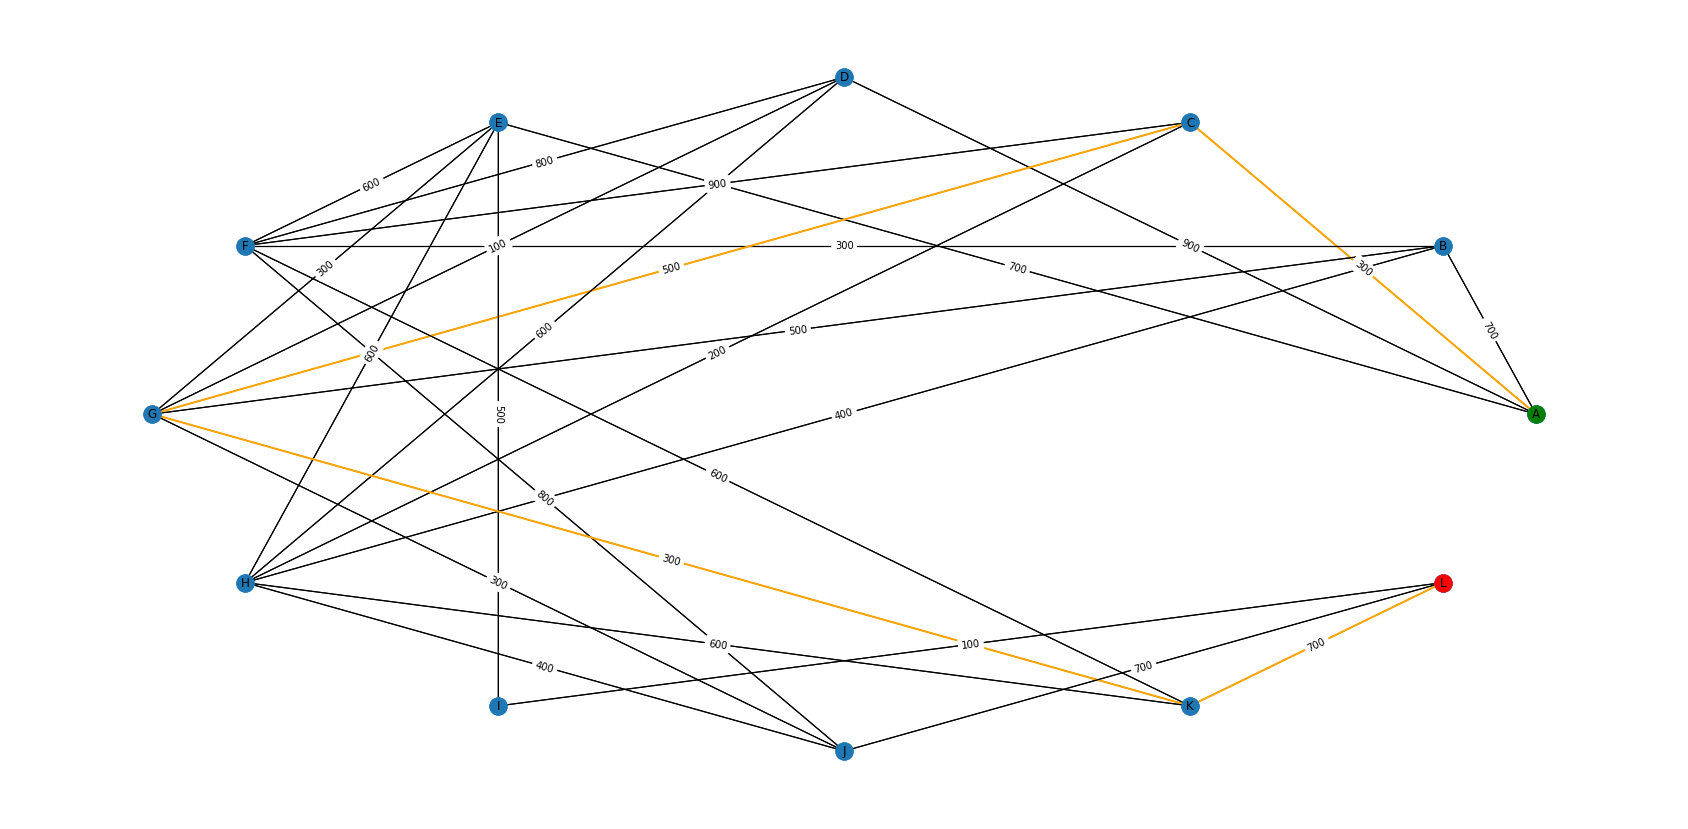</center>

### Imports

In [6]:
import numpy as np
from math import exp
from time import time
from copy import deepcopy
from random import choice, random

### Clase <b>SearchProblem</b>

Esta es una clase abstracta para definir problemas de busqueda. Se debe hacer subclases que implementen los metodos 'initial', 'score', 'get_neighborhood' y 'get_random_neighbor'. Entonces, se puede instanciar las subclases para resolverlas mediante funciones de búsqueda.

**( No modificar )**

In [7]:
class SearchProblem(object):
    def __init__(self, *params):
        """ Initialize a search problem """
        pass

    def initial(self):
        """ Return default initial state of the search problem """
        pass

    def score(self, state):
        """ Return the score of the state. This is the objective function to be optimized """
        pass

    def get_neighborhood(self, state):
        """ Return the neighboring states of the given state """
        pass

    def get_random_neighbor(self, state):
        """ Return a random neighbor of the neighborhood of the state (this method is used in simulated annealing) """
        return choice(self.neighborhood(state))

### Clase <b>AntennaSearch</b>

La clase AntennaSearch implementa concretamente el problema de la conexión mediante antenas de una ciudad de origen y destino. Esta conexión se representa mediante una lista de ciudades, donde el primer y último valor son las ciudades de origen y destino, respectivamente. La lista de ciudades indica el orden en el que se deben recorrer las ciudades para conectar la ciudad de origen y destino. Adicionalmente, mediante el método "score" se obtiene que tan costosa es una conexión.

In [8]:
class AntennaSearch(SearchProblem):
    def __init__(self, distances_matrix, cities_names, origin_city, destination_city):
        self.cities_names = cities_names
        self.distances_matrix = distances_matrix
        self.origin_city = origin_city
        self.destination_city = destination_city

    def initial(self):
        """ Genera una solución bajo el supuesto que las ciudades intermedias están lo suficientemente
            conectadas tal que permitan llegar desde self.origin_city hacia self.destination_city sin
            importar las ciudades intermedias elegidas """
        origin_city_index = self.cities_names.index(self.origin_city)
        destination_city_index = self.cities_names.index(self.destination_city)

        path = list()
        visited_cities = set()

        index = origin_city_index

        path.append(index)
        visited_cities.add(index)

        while index != destination_city_index:
            cities_connected = list()

            for city_index, distance in enumerate(self.distances_matrix[index]):
                if (city_index != index) and (distance != None) and (city_index not in visited_cities):
                    cities_connected.append(city_index)

            index = cities_connected[0]

            path.append(index)
            visited_cities.update(cities_connected)

        return path

    def score(self, state):
        """ Retorna el costo total de las antenas usadas sumado al costo total de las antenas y los cables entre las
            ciudades de "state", siendo que una antena tiene un costo de 150 y que la distancia entre
            dos ciudades se obtiene consultando 'self.distances_matrix' """
        total_distance = len(state) * 150

        for index in range(len(state)-1):
            first = state[index]
            second = state[index+1]

            distance = self.distances_matrix[first][second]

            total_distance += distance

        return total_distance

    def get_neighborhood(self, state):
        """ Crea soluciones vecinas a partir de "state"; la forma en como se realiza este proceso es haciendo
            uso de la lista de ciudades que conforman state, de la cual se extraen 2 ciudades y se verifica si
            existe otra ciudad permita conectarlas, preservando en todo momento el orden en el que aparecen
            las ciudades.

            Por ejemplo, para el "state" [0, 1, 5, 9, 11] los posibles vecinos son:
                  [0, 2, 5, 9, 11], [0, 3, 5, 9, 11], [0, 4, 5, 9, 11], [0, 1, 6, 9, 11], [0, 1, 7, 9, 11] y
                  [0, 1, 5, 10, 11] """
        neighborhood = list()
        visited_neighbors = set()

        len_state = len(state)
        state_as_tuple = tuple(state)

        for i in range(len_state-1):
            for j in range(i+1, len_state):
                origin_city = state[i]
                destination_city = state[j]

                for city_index, connections in enumerate(self.distances_matrix):
                    if (city_index != origin_city) and (city_index != destination_city) and (connections[origin_city] != None) and (connections[destination_city] != None):
                        neighbor = state[:i] + [origin_city, city_index, destination_city] + state[j+1:]

                        neighbor_as_tuple = tuple(neighbor)

                        if (neighbor_as_tuple != state_as_tuple) and (neighbor_as_tuple not in visited_neighbors):
                            visited_neighbors.add(neighbor_as_tuple)
                            neighborhood.append(neighbor)

        return neighborhood

    def get_random_neighbor(self, state):
        """ Crea una solución vecina aleatoria a partir de "state"; el procedimiento a seguir es el mismo que
            el del método "get_neighborhood" con la diferencia que se escoge aleatoriamente un vecino de todas
            las posibilidades generadas al verificar si una ciudad permite conectar 2 ciudades, para crear una
            lista de vecinos escogidos aleatoriamente a partir de la cual al final se selecciona de manera
            aleatoria uno de estos vecinos aleatorios """
        selected_neighbors = list()
        visited_neighbors = set()

        len_state = len(state)
        state_as_tuple = tuple(state)

        for i in range(len_state-1):
            for j in range(i+1, len_state):
                origin_city = state[i]
                destination_city = state[j]

                possible_neighbors = list()

                for city_index, connections in enumerate(self.distances_matrix):
                    if (city_index != origin_city) and (city_index != destination_city) and (connections[origin_city] != None) and (connections[destination_city] != None):
                        neighbor = state[:i] + [origin_city, city_index, destination_city] + state[j+1:]

                        neighbor_as_tuple = tuple(neighbor)

                        if (neighbor_as_tuple != state_as_tuple) and (neighbor_as_tuple not in visited_neighbors):
                            visited_neighbors.add(neighbor_as_tuple)
                            possible_neighbors.append(neighbor)

                if len(possible_neighbors) > 0:
                    selected_neighbor = choice(possible_neighbors)
                    selected_neighbors.append(selected_neighbor)

        if len(selected_neighbors) > 0:
            random_neighbor = choice(selected_neighbors)
        else:
            random_neighbor = None

        return random_neighbor

### Funciones utilitarias para manejar la matriz de distancias</b>
Estas son funciones utilitarias para mostrar e interpretar las conexiones entre las ciudades

**( No modificar )**

In [9]:
def interpret_index_as_city(cities_names, index):
    return cities_names[index]

def interpret_indexes_as_cities(cities_names, index_list):  # muestra un camino solucion con nombres en vez de indices de ciudades
    return [interpret_index_as_city(cities_names, index) for index in index_list]

def show_distances_for_cities(distances_matrix, cities_names):  # muestra las distancias entre ciudades de forma amigable
    for i, connections in enumerate(distances_matrix):
        connections_between_cities = list()

        for j, distance in enumerate(connections):
            if (j != i) and (distance != None):
                origin_city = interpret_index_as_city(cities_names, i)
                destination_city = interpret_index_as_city(cities_names, j)

                connections_between_cities.append("{} -{}-> {}".format(origin_city, distance, destination_city))

        print(" | ".join(connections_between_cities))

## <b>Algoritmos de Búsqueda Local</b>

### <b>Hill-climbing </b>

Implementación del algoritmo para la resolución de AntennaSearch

In [54]:
def hill_climbing_solver(problem, max_iter=1000):
    """ Hill Climbing solver.
           max_iter: The maximum number of iterations
    """
    ############################################### COMPLETAR ###############################################

    # Debe completar las secciones faltantes del algoritmo para que funcione correctamente

    # Se busca que el problema a resolver sea de MAXIMIZACIÓN en lugar de minimización.
    # Recuerde que la funcion score() es de costo (da mayores valores a peores soluciones). Debe completar el codigo para
    # encontrar una ruta con la menor distancia total entre las ciudades y el menor costo total de las antenas usadas

    # No está permitido modificar el código elaborado en el método 'score' de la variable 'problem'

    #########################################################################################################
    start_time = time()

    print("Hill Climbing intentará resolver encontrar el mejor camino para llegar desde la ciudad {} hacia la ciudad {}".format(problem.origin_city, problem.destination_city))
    print()

    current = problem.initial() # Obtiene la solución inicial
    current_score = - problem.score(current) # Evalúa la solución inicial __

    print("Solución inicial:")
    print(current)
    print(interpret_indexes_as_cities(problem.cities_names, current))
    print()

    t = 0

    while (t < max_iter):
        if (t % 100 == 0):
            print("Iteración {},\tScore actual = {}".format(t, current_score))

        neighborhood = problem.get_neighborhood(current)   # obtiene los estados vecinos de current

        if len(neighborhood) == 0: # Si no hay estados vecinos
            break

        neighborhood_scores = list()

        for i in range(len(neighborhood)): # Evalúa cada estado vecino
            neighborhood_scores.append(- problem.score(neighborhood[i]))   #WARNING: no olvidar que la funcion score() es de costo (da mayores valores a peores soluciones) ___

        index_best_neighbor = np.argmax(neighborhood_scores) # Obtiene el indice del mejor vecino. TIP: le puede servir np.argmax() o np.argmin() de numpy___

        if current_score < neighborhood_scores[index_best_neighbor]: # Si el camino del mejor estado vecino es mejor que el camino actual__
            current_score = neighborhood_scores[index_best_neighbor]
            current = deepcopy(neighborhood[index_best_neighbor])

        t += 1

    end_time = time()

    total_time = end_time - start_time

    print("{:.5f} segundos ({} iteraciones) con {} puntos:".format(total_time, t, current_score))

    print()
    print("Solución final:")
    print(current)
    print(interpret_indexes_as_cities(problem.cities_names, current))
    print()
    #########################################################################################################

### <b>Simulating Annealing</b>
Implementación del algoritmo para la resolución de AntennaSearch

In [38]:
def simulated_annealing_solver(problem, T0, DR, max_iter):
    """ Simulating Annealing solver.
           T0: Initial temperature
           DR: The decay rate of the schedule function: Ti = T0*(DR)^i (Ti is the temperature at iteration i).
               For efficiecy the schedule function is implemented as: Ti = T(i-1)*DR
           max_iter: The maximum number of iterations
    """
    ############################################### COMPLETAR ###############################################

    # Debe completar las secciones faltantes del algoritmo para que funcione correctamente

    # Se busca que el problema a resolver sea de MAXIMIZACIÓN en lugar de minimización.
    # Recuerde que la funcion score() es de costo (da mayores valores a peores soluciones). Debe completar el codigo para
    # encontrar una ruta con la menor distancia total entre las ciudades y el menor costo total de las antenas usadas

    # No está permitido modificar el código elaborado en el método 'score' de la variable 'problem'

    #########################################################################################################
    start_time = time()

    print("Simulated Annealing intentará resolver encontrar el mejor camino para llegar desde la ciudad {} hacia la ciudad {}".format(problem.origin_city, problem.destination_city))
    print()

    current = problem.initial() # Obtiene la solución inicial
    current_score = - problem.score(current) # Evalúa la solución inicial___

    best = deepcopy(current)
    best_score = current_score

    print("Solución inicial:")
    print(current)
    print(interpret_indexes_as_cities(problem.cities_names, current))
    print()

    T = T0  # El valor inicial de la temperatura
    t = 0

    try:
        while (t < max_iter):
            if (t % 10000 == 0):
                print("Iteración {},\tTemperatura ={},\tMejor score = {},\tScore actual = {}".format(t, T, best_score, current_score))

            neighbor = problem.get_random_neighbor(current)   # obtiene un estado vecino de current (TIP: use get_random_neighbor())

            if neighbor == None: # Si no hay vecinos o si es la mejor ruta posible
                break

            neighbor_score = - problem.score(neighbor) # Evalúa el neighbor___
            delta = float(  neighbor_score - current_score)  # Diferencia entre el score del vecino con respecto al actual___

            if current_score < neighbor_score:   # Si el vecino generado es mejor que el actual, se acepta___
                current = neighbor
                current_score = neighbor_score
            elif exp((delta/T)) > random():  # Si el vecino generado es peor (delta es negativo), se acepta con probabilidad exp((delta/T))
                current = neighbor
                current_score = neighbor_score

            if best_score < current_score:  # Si el camino actual es mejor que el mejor camino encontado hasta ahora
                best = deepcopy(current)
                best_score = current_score

            T = DR * T   # La nueva temperatura decae con un factor de decaimiento DR, es una forma eficiente del schedule Ti = T0*(DR)^i
            t += 1
    except:
        print("Iteración {},\tOcurrió un error numérico,\tAl ser un algoritmo aleatorio se intentará de nuevo.".format(t))

    end_time = time()

    total_time = end_time - start_time

    print("{:.5f} segundos ({} iteraciones) con {} puntos:".format(total_time, t, best_score))

    print()
    print("Solución final:")
    print(best)
    print(interpret_indexes_as_cities(problem.cities_names, best))
    print()
    #########################################################################################################

## <b> Experimentación con los algoritmos de Búsqueda</b>

Inicialización de los nombres y de las distancias entre las ciudades junto a la ciudad de origen y destino

**( No modificar )**

In [46]:
cities_names = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L"]

distances_matrix = [[None, 700, 300, 900, 700, None, None, None, None, None, None, None],
                    [700, None, None, None, None, 300, 500, 400, None, None, None, None],
                    [300, None, None, None, None, 900, 500, 200, None, None, None, None],
                    [900, None, None, None, None, 800, 100, 600, None, None, None, None],
                    [700, None, None, None, None, 600, 300, 600, 500, None, None, None],
                    [None, 300, 900, 800, 600, None, None, None, None, 800, 600, None],
                    [None, 500, 500, 100, 300, None, None, None, None, 300, 300, None],
                    [None, 400, 200, 600, 600, None, None, None, None, 400, 600, None],
                    [None, None, None, None, 500, None, None, None, None, None, None, 100],
                    [None, None, None, None, None, 800, 300, 400, None, None, None, 700],
                    [None, None, None, None, None, 600, 300, 600, None, None, None, 700],
                    [None, None, None, None, None, None, None, None, 100, 700, 700, None]]

In [47]:
origin_city = "A"
destination_city = "L"

problem = AntennaSearch(distances_matrix, cities_names, origin_city, destination_city)

In [48]:
print("Distances between Cities:")
show_distances_for_cities(problem.distances_matrix, problem.cities_names)

Distances between Cities:
A -700-> B | A -300-> C | A -900-> D | A -700-> E
B -700-> A | B -300-> F | B -500-> G | B -400-> H
C -300-> A | C -900-> F | C -500-> G | C -200-> H
D -900-> A | D -800-> F | D -100-> G | D -600-> H
E -700-> A | E -600-> F | E -300-> G | E -600-> H | E -500-> I
F -300-> B | F -900-> C | F -800-> D | F -600-> E | F -800-> J | F -600-> K
G -500-> B | G -500-> C | G -100-> D | G -300-> E | G -300-> J | G -300-> K
H -400-> B | H -200-> C | H -600-> D | H -600-> E | H -400-> J | H -600-> K
I -500-> E | I -100-> L
J -800-> F | J -300-> G | J -400-> H | J -700-> L
K -600-> F | K -300-> G | K -600-> H | K -700-> L
L -100-> I | L -700-> J | L -700-> K


In [49]:
print("Initial State:")
problem.initial()

Initial State:


[0, 1, 5, 9, 11]

In [50]:
print("Initial State with Cities Names:")
interpret_indexes_as_cities(problem.cities_names, problem.initial())

Initial State with Cities Names:


['A', 'B', 'F', 'J', 'L']

### Hill Climbing

Invoque 5 veces a Hill Climbing para resolver el problema de la conexión entre ciudades

Usar: max_iter=1000

In [55]:
############################################### COMPLETAR ###############################################

# Debe completar la invocación a Hill Climbing

#########################################################################################################
print("Invocación n° 1")
hill_climbing_solver(problem, 1000)
#########################################################################################################___

Invocación n° 1
Hill Climbing intentará resolver encontrar el mejor camino para llegar desde la ciudad A hacia la ciudad L

Solución inicial:
[0, 1, 5, 9, 11]
['A', 'B', 'F', 'J', 'L']

Iteración 0,	Score actual = -3250
Iteración 100,	Score actual = -2350
Iteración 200,	Score actual = -2350
Iteración 300,	Score actual = -2350
Iteración 400,	Score actual = -2350
Iteración 500,	Score actual = -2350
Iteración 600,	Score actual = -2350
Iteración 700,	Score actual = -2350
Iteración 800,	Score actual = -2350
Iteración 900,	Score actual = -2350
0.08858 segundos (1000 iteraciones) con -2350 puntos:

Solución final:
[0, 2, 7, 9, 11]
['A', 'C', 'H', 'J', 'L']



In [56]:
############################################### COMPLETAR ###############################################

# Debe completar la invocación a Hill Climbing

#########################################################################################################
print("Invocación n° 2")
hill_climbing_solver(problem, 1000)
#########################################################################################################

Invocación n° 2
Hill Climbing intentará resolver encontrar el mejor camino para llegar desde la ciudad A hacia la ciudad L

Solución inicial:
[0, 1, 5, 9, 11]
['A', 'B', 'F', 'J', 'L']

Iteración 0,	Score actual = -3250
Iteración 100,	Score actual = -2350
Iteración 200,	Score actual = -2350
Iteración 300,	Score actual = -2350
Iteración 400,	Score actual = -2350
Iteración 500,	Score actual = -2350
Iteración 600,	Score actual = -2350
Iteración 700,	Score actual = -2350
Iteración 800,	Score actual = -2350
Iteración 900,	Score actual = -2350
0.07545 segundos (1000 iteraciones) con -2350 puntos:

Solución final:
[0, 2, 7, 9, 11]
['A', 'C', 'H', 'J', 'L']



In [57]:
############################################### COMPLETAR ###############################################

# Debe completar la invocación a Hill Climbing

#########################################################################################################
print("Invocación n° 3")
hill_climbing_solver(problem, 1000)
#########################################################################################################

Invocación n° 3
Hill Climbing intentará resolver encontrar el mejor camino para llegar desde la ciudad A hacia la ciudad L

Solución inicial:
[0, 1, 5, 9, 11]
['A', 'B', 'F', 'J', 'L']

Iteración 0,	Score actual = -3250
Iteración 100,	Score actual = -2350
Iteración 200,	Score actual = -2350
Iteración 300,	Score actual = -2350
Iteración 400,	Score actual = -2350
Iteración 500,	Score actual = -2350
Iteración 600,	Score actual = -2350
Iteración 700,	Score actual = -2350
Iteración 800,	Score actual = -2350
Iteración 900,	Score actual = -2350
0.09128 segundos (1000 iteraciones) con -2350 puntos:

Solución final:
[0, 2, 7, 9, 11]
['A', 'C', 'H', 'J', 'L']



In [58]:
############################################### COMPLETAR ###############################################

# Debe completar la invocación a Hill Climbing

#########################################################################################################
print("Invocación n° 4")
hill_climbing_solver(problem, 1000)
#########################################################################################################

Invocación n° 4
Hill Climbing intentará resolver encontrar el mejor camino para llegar desde la ciudad A hacia la ciudad L

Solución inicial:
[0, 1, 5, 9, 11]
['A', 'B', 'F', 'J', 'L']

Iteración 0,	Score actual = -3250
Iteración 100,	Score actual = -2350
Iteración 200,	Score actual = -2350
Iteración 300,	Score actual = -2350
Iteración 400,	Score actual = -2350
Iteración 500,	Score actual = -2350
Iteración 600,	Score actual = -2350
Iteración 700,	Score actual = -2350
Iteración 800,	Score actual = -2350
Iteración 900,	Score actual = -2350
0.06480 segundos (1000 iteraciones) con -2350 puntos:

Solución final:
[0, 2, 7, 9, 11]
['A', 'C', 'H', 'J', 'L']



In [59]:
############################################### COMPLETAR ###############################################

# Debe completar la invocación a Hill Climbing

#########################################################################################################
print("Invocación n° 5")
hill_climbing_solver(problem, 1000)
#########################################################################################################

Invocación n° 5
Hill Climbing intentará resolver encontrar el mejor camino para llegar desde la ciudad A hacia la ciudad L

Solución inicial:
[0, 1, 5, 9, 11]
['A', 'B', 'F', 'J', 'L']

Iteración 0,	Score actual = -3250
Iteración 100,	Score actual = -2350
Iteración 200,	Score actual = -2350
Iteración 300,	Score actual = -2350
Iteración 400,	Score actual = -2350
Iteración 500,	Score actual = -2350
Iteración 600,	Score actual = -2350
Iteración 700,	Score actual = -2350
Iteración 800,	Score actual = -2350
Iteración 900,	Score actual = -2350
0.08601 segundos (1000 iteraciones) con -2350 puntos:

Solución final:
[0, 2, 7, 9, 11]
['A', 'C', 'H', 'J', 'L']



### Simulated Annealing

Invoque 5 veces a Simulated Annealing para resolver el problema de la conexión entre ciudades

Usar: T0=0.5, DR=0.99999 y max_iter=100000

In [39]:
############################################### COMPLETAR ###############################################

# Debe completar la invocación a Simulated Annealing

#########################################################################################################
print("Invocación n° 1")
simulated_annealing_solver(problem, 0.5, 0.99999, max_iter=100000)
#########################################################################################################

Invocación n° 1
Simulated Annealing intentará resolver encontrar el mejor camino para llegar desde la ciudad A hacia la ciudad L

Solución inicial:
[0, 1, 5, 9, 11]
['A', 'B', 'F', 'J', 'L']

Iteración 0,	Temperatura =0.5,	Mejor score = -3250,	Score actual = -3250
Iteración 10000,	Temperatura =0.45241848280737684,	Mejor score = -2350,	Score actual = -2350
Iteración 20000,	Temperatura =0.4093649671714617,	Mejor score = -2350,	Score actual = -2350
Iteración 30000,	Temperatura =0.3704085547244124,	Mejor score = -2350,	Score actual = -2350
Iteración 40000,	Temperatura =0.33515935269458563,	Mejor score = -2350,	Score actual = -2350
Iteración 50000,	Temperatura =0.3032645716895745,	Mejor score = -2350,	Score actual = -2350
Iteración 60000,	Temperatura =0.2744049948260552,	Mejor score = -2350,	Score actual = -2350
Iteración 70000,	Temperatura =0.24829178286794154,	Mejor score = -2350,	Score actual = -2350
Iteración 80000,	Temperatura =0.22466358339730758,	Mejor score = -2350,	Score actual = -

In [40]:
############################################### COMPLETAR ###############################################

# Debe completar la invocación a Simulated Annealing

#########################################################################################################
print("Invocación n° 2")
simulated_annealing_solver(problem, 0.5, 0.99999, max_iter=100000)
#########################################################################################################

Invocación n° 2
Simulated Annealing intentará resolver encontrar el mejor camino para llegar desde la ciudad A hacia la ciudad L

Solución inicial:
[0, 1, 5, 9, 11]
['A', 'B', 'F', 'J', 'L']

Iteración 0,	Temperatura =0.5,	Mejor score = -3250,	Score actual = -3250
Iteración 10000,	Temperatura =0.45241848280737684,	Mejor score = -2350,	Score actual = -2350
Iteración 20000,	Temperatura =0.4093649671714617,	Mejor score = -2350,	Score actual = -2350
Iteración 30000,	Temperatura =0.3704085547244124,	Mejor score = -2350,	Score actual = -2350
Iteración 40000,	Temperatura =0.33515935269458563,	Mejor score = -2350,	Score actual = -2350
Iteración 50000,	Temperatura =0.3032645716895745,	Mejor score = -2350,	Score actual = -2350
Iteración 60000,	Temperatura =0.2744049948260552,	Mejor score = -2350,	Score actual = -2350
Iteración 70000,	Temperatura =0.24829178286794154,	Mejor score = -2350,	Score actual = -2350
Iteración 80000,	Temperatura =0.22466358339730758,	Mejor score = -2350,	Score actual = -

In [41]:
############################################### COMPLETAR ###############################################

# Debe completar la invocación a Simulated Annealing

#########################################################################################################
print("Invocación n° 3")
simulated_annealing_solver(problem, 0.5, 0.99999, max_iter=100000)
#########################################################################################################

Invocación n° 3
Simulated Annealing intentará resolver encontrar el mejor camino para llegar desde la ciudad A hacia la ciudad L

Solución inicial:
[0, 1, 5, 9, 11]
['A', 'B', 'F', 'J', 'L']

Iteración 0,	Temperatura =0.5,	Mejor score = -3250,	Score actual = -3250
Iteración 10000,	Temperatura =0.45241848280737684,	Mejor score = -2350,	Score actual = -2350
Iteración 20000,	Temperatura =0.4093649671714617,	Mejor score = -2350,	Score actual = -2350
Iteración 30000,	Temperatura =0.3704085547244124,	Mejor score = -2350,	Score actual = -2350
Iteración 40000,	Temperatura =0.33515935269458563,	Mejor score = -2350,	Score actual = -2350
Iteración 50000,	Temperatura =0.3032645716895745,	Mejor score = -2350,	Score actual = -2350
Iteración 60000,	Temperatura =0.2744049948260552,	Mejor score = -2350,	Score actual = -2350
Iteración 70000,	Temperatura =0.24829178286794154,	Mejor score = -2350,	Score actual = -2350
Iteración 80000,	Temperatura =0.22466358339730758,	Mejor score = -2350,	Score actual = -

In [42]:
############################################### COMPLETAR ###############################################

# Debe completar la invocación a Simulated Annealing

#########################################################################################################
print("Invocación n° 4")
simulated_annealing_solver(problem, 0.5, 0.99999, max_iter=100000)
#########################################################################################################

Invocación n° 4
Simulated Annealing intentará resolver encontrar el mejor camino para llegar desde la ciudad A hacia la ciudad L

Solución inicial:
[0, 1, 5, 9, 11]
['A', 'B', 'F', 'J', 'L']

Iteración 0,	Temperatura =0.5,	Mejor score = -3250,	Score actual = -3250
Iteración 10000,	Temperatura =0.45241848280737684,	Mejor score = -2350,	Score actual = -2350
Iteración 20000,	Temperatura =0.4093649671714617,	Mejor score = -2350,	Score actual = -2350
Iteración 30000,	Temperatura =0.3704085547244124,	Mejor score = -2350,	Score actual = -2350
Iteración 40000,	Temperatura =0.33515935269458563,	Mejor score = -2350,	Score actual = -2350
Iteración 50000,	Temperatura =0.3032645716895745,	Mejor score = -2350,	Score actual = -2350
Iteración 60000,	Temperatura =0.2744049948260552,	Mejor score = -2350,	Score actual = -2350
Iteración 70000,	Temperatura =0.24829178286794154,	Mejor score = -2350,	Score actual = -2350
Iteración 80000,	Temperatura =0.22466358339730758,	Mejor score = -2350,	Score actual = -

In [43]:
############################################### COMPLETAR ###############################################

# Debe completar la invocación a Simulated Annealing

#########################################################################################################
print("Invocación n° 5")
simulated_annealing_solver(problem, 0.5, 0.99999, max_iter=100000)
#########################################################################################################

Invocación n° 5
Simulated Annealing intentará resolver encontrar el mejor camino para llegar desde la ciudad A hacia la ciudad L

Solución inicial:
[0, 1, 5, 9, 11]
['A', 'B', 'F', 'J', 'L']

Iteración 0,	Temperatura =0.5,	Mejor score = -3250,	Score actual = -3250
Iteración 10000,	Temperatura =0.45241848280737684,	Mejor score = -2350,	Score actual = -2350
Iteración 20000,	Temperatura =0.4093649671714617,	Mejor score = -2350,	Score actual = -2350
Iteración 30000,	Temperatura =0.3704085547244124,	Mejor score = -2350,	Score actual = -2350
Iteración 40000,	Temperatura =0.33515935269458563,	Mejor score = -2350,	Score actual = -2350
Iteración 50000,	Temperatura =0.3032645716895745,	Mejor score = -2350,	Score actual = -2350
Iteración 60000,	Temperatura =0.2744049948260552,	Mejor score = -2350,	Score actual = -2350
Iteración 70000,	Temperatura =0.24829178286794154,	Mejor score = -2350,	Score actual = -2350
Iteración 80000,	Temperatura =0.22466358339730758,	Mejor score = -2350,	Score actual = -

# Preguntas:

<b>1. Completar correctamente el código de la búsqueda Hill Climbing considerando que se quiere encontrar el camino menos costoso. (4 pts)</b>

<b>2. Completar correctamente el código de la búsqueda Simulating Annealing considerando que se quiere encontrar el camino menos costoso. (4 pts)</b>

<b>3. Luego de realizar la experimentación (5 veces) con los algoritmos de búsqueda Hill Climbing y Simulating Annealing, ¿cuál de ellos tiende a generar soluciones más óptimas?. Justifique su respuesta relacionando con la teoría. (4 pts)</b>

El algoritmo que tiende a generar soluciones más óptimas es el Simulating Annealing ya que en el caso de Hill Climbing este puede no encontrar la solución óptima debido a máximos locales, crestas o mesetas que son áreas de exploración donde el algoritmo se queda perdido y es dificil de explorar por sus vecinos. En el caso de Simulating Annealing combina Hill Climbing pero le añade el factor aleatorio y de "temperatura" para poder explorar todo de mejor manera y no quedarse perdido en una meseta o asumir como solución un máximo local


<b>4. ¿Cómo se controla el grado de exploración en el algoritmo Simulating Annealing relacionado a a la convergencia y los óptimos locales? (2 pts)</b>

Con la temperatura, dependiendo de la temperatura y el uso en su fórmula, nos da la probabilidad de que un estado vecino sea escogidos, permitiendo escapar de maximos globales y la convergencia.

<b>5. ¿Cuál es la ventaja de Simulating Annealing respecto de Hill Climbing ? (2 pts)</b>

La ventaja de Simulating Annealing a comparación de Hill Climbing es que en el caso de Hill Climbing es probable que el algoritmo se quede perdido en algun momento debido a maximos locales que asume como solución, mesetas planas donde se queda perdido y posibles crestas, Simulating Annealing gracias a sus caminos aleatorios y "temperatura" ofrece completitud y eficiencia en el algoritmo evitando los problemas de Hill Climbing

<b>6. En el presente laboratorio se ha implementado búsqueda de caminos con Hill Climbing y Simulating Annealing, ¿Qué diferencias puede apreciar de esta forma de búsqueda en relación a utilizar A* para la búsqueda de caminos?. Justifique su respuesta expresando dichas diferencias respecto al espacio de estados, la optimalidad y la memoria usada. (4 pts)</b>

En el caso de A* se utilza una heuristica apropiada junto con el costo y dependiendo de este se obtiene una solución óptima, evaluando en un tipo de arbol, Hill Climbing y Simulating Annealing lo que ofrece es primero tener un estado o solución inicial y obtener ya sea una lista de vecinos o un vecino aleatorio que nos pueda servir y ayudandonos de metodos matematicos como la "temperatura" en el caso de Simulating Annealing obtener la solución óptima.  El algoritmo que usualmente usa menor memoria son la de busqueda local(Hill Climbing y Simulating Annealing) en comparacion a A*, aparte de poder resover problemas mas largos o de estados infinitos donde metodos que exploran caminos no funcionarian.